In [165]:
%load_ext autoreload
%autoreload 2

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from Levenshtein import distance

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_transtions import TransitionMetrics

warnings.filterwarnings("ignore")


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [166]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [167]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df['cell_label'] = june.df['cell_label'].apply(lambda x: x + ',' if x else x)

june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1


In [168]:
from sklearn.preprocessing import MultiLabelBinarizer

labels = june.df.cell_label.fillna("").apply(lambda x: x.split(",")[:-1])

mlb = MultiLabelBinarizer()

onehot_labels = pd.DataFrame(
    mlb.fit_transform(labels),
    columns=mlb.classes_,
    index=labels.index
)
onehot_labels.head()


,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [169]:
labels = ['helper_functions', 'load_data', 'data_exploration',
          'data_preprocessing', 'result_visualization', 'save_results', 'modelling', 'evaluation',
          'prediction'
          ]

df_with_onehot = pd.concat([june.df, onehot_labels], axis=1)
label_count_per_cell = df_with_onehot[labels].sum(axis=1).values
df_with_single_label = df_with_onehot[label_count_per_cell == 1]
df_with_single_label['cell_label'] = df_with_single_label.cell_label.fillna("").apply(
    lambda x: x.strip().split(',')[0]
)
df_with_single_label.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
5,5,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0


In [170]:
df_with_single_label = df_with_single_label[df_with_single_label.cell_label != "comment_only"]


# Transitions calculation

In [171]:
processor = TransitionMetrics()
all_transitions = processor.calculate_metrics(df_with_single_label)
all_transitions.head()


100%|██████████| 31/31 [00:00<00:00, 6944.21it/s]


,kernel_id,cell_idx_from,cell_num_from,cell_source_from,cell_idx_to,cell_num_to,cell_source_to,cell_label_from,cell_label_to,inner_transition,type,event_from,event_to
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,e139884774504ae997d7e38e6be6da88,0.0,# # Do not forget to check if your notebook lo...,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,helper_functions,helper_functions,False,execution_transition,NaN,NaN
1,0033f76c-6179-4fb4-a9ce-79112a52b51c,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,helper_functions,helper_functions,False,execution_transition,NaN,NaN
2,0033f76c-6179-4fb4-a9ce-79112a52b51c,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,helper_functions,helper_functions,False,execution_transition,NaN,NaN
3,0033f76c-6179-4fb4-a9ce-79112a52b51c,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,helper_functions,helper_functions,False,execution_transition,NaN,NaN
4,0033f76c-6179-4fb4-a9ce-79112a52b51c,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,8fd58da2205544c1a978c43701cd5678,0.0,# # Do not forget to check if your notebook lo...,helper_functions,helper_functions,False,execution_transition,NaN,NaN


In [172]:
execution_transitions = all_transitions[all_transitions.type == "execution_transition"]
execution_transitions.shape


(6511, 13)

In [173]:
all_transitions_merged = execution_transitions.merge(
    june.df[['task', 'kernel_id', 'expert']].drop_duplicates(subset=['task', 'kernel_id'], keep='last'),
    on='kernel_id'
)
all_transitions_merged.head()


,kernel_id,cell_idx_from,cell_num_from,cell_source_from,cell_idx_to,cell_num_to,cell_source_to,cell_label_from,cell_label_to,inner_transition,type,event_from,event_to,task,expert
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,e139884774504ae997d7e38e6be6da88,0.0,# # Do not forget to check if your notebook lo...,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
1,0033f76c-6179-4fb4-a9ce-79112a52b51c,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
2,0033f76c-6179-4fb4-a9ce-79112a52b51c,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
3,0033f76c-6179-4fb4-a9ce-79112a52b51c,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
4,0033f76c-6179-4fb4-a9ce-79112a52b51c,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,8fd58da2205544c1a978c43701cd5678,0.0,# # Do not forget to check if your notebook lo...,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False


# Analysis

In [174]:
working_with_data_fraction = all_transitions_merged[
    all_transitions_merged.cell_label_from.isin(['data_preprocessing', 'data_exploration'])
    & all_transitions_merged.cell_label_to.isin(['data_preprocessing', 'data_exploration'])
    ].shape[0] / all_transitions_merged.shape[0]

print(np.around(working_with_data_fraction * 100, 1), '%')

56.1 %


In [175]:
grouped_transitions = all_transitions_merged.groupby(['cell_label_from']) \
    .cell_label_to.value_counts().reset_index().rename({"count": "transitions_count"}, axis=1)

grouped_transitions['probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

grouped_transitions.head()


,cell_label_from,cell_label_to,transitions_count,probability
0,data_exploration,data_exploration,1525,0.234219
1,data_exploration,data_preprocessing,424,0.065121
2,data_exploration,helper_functions,204,0.031332
3,data_exploration,result_visualization,91,0.013976
4,data_exploration,load_data,45,0.006911


In [176]:
transitions_matrix = grouped_transitions.pivot(
    index='cell_label_from', columns='cell_label_to', values='probability'
).fillna(0)
transitions_matrix


cell_label_to,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
cell_label_from,,,,,,,,,
data_exploration,0.234219,0.065121,0.000154,0.031332,0.006911,0.004761,0.001382,0.013976,0.001075
data_preprocessing,0.063738,0.198280,0.000154,0.023192,0.007065,0.007833,0.000461,0.002765,0.000000
evaluation,0.000154,0.000154,0.000768,0.000922,0.000000,0.000154,0.000154,0.000000,0.000000
helper_functions,0.027031,0.016127,0.000614,0.083090,0.017509,0.004147,0.003840,0.003072,0.000000
load_data,0.015819,0.013055,0.000000,0.005376,0.021502,0.000000,0.000154,0.000154,0.000000
modelling,0.002304,0.004300,0.000461,0.002304,0.001843,0.029335,0.013823,0.000922,0.000154
prediction,0.003225,0.004147,0.000307,0.002918,0.000461,0.007986,0.010137,0.000154,0.000000
result_visualization,0.013669,0.002918,0.000000,0.002611,0.000154,0.001229,0.000000,0.017355,0.000000
save_results,0.000614,0.000000,0.000000,0.000154,0.000000,0.000154,0.000000,0.000000,0.000154


In [177]:
def plot_transitions_matrix(matrix, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(12, 9))
    else:
        fig, ax = fig_ax

    full_matrix = pd.DataFrame(columns=labels, index=labels)
    full_matrix.loc[labels, labels] = matrix
    full_matrix = full_matrix.fillna(-1)
    mask = np.where(full_matrix == -1, True, False)

    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_bad(color='grey', alpha=0.1)

    annotations = (full_matrix.copy().round(2) * 100).astype(int).astype(object)
    annotations[full_matrix < 0.01] = "<1%"
    annotations[~(full_matrix < 0.01)] = annotations[~(full_matrix < 0.01)].astype(str) + '%'

    ax = sns.heatmap(
        full_matrix.fillna(-1),
        annot=annotations,
        fmt="", cmap=cmap, mask=mask,
        linewidths=1,
        square=True, robust=True, ax=ax, cbar=False,
        annot_kws={"fontsize": 10}
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right'
    )

    return fig, ax


In [178]:
task, expert = 'task2', True
grouped_transitions = all_transitions_merged \
    .groupby(['task', 'expert']).get_group((task, expert)) \
    .groupby(['cell_label_from']).cell_label_to.value_counts() \
    .reset_index().rename({"count": "transitions_count"}, axis=1)

grouped_transitions['probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

transitions_matrix = grouped_transitions.pivot(
    index='cell_label_from', columns='cell_label_to', values='probability'
).fillna(0)
transitions_matrix


cell_label_to,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
cell_label_from,,,,,,,,,
data_exploration,0.142205,0.025095,0.000760,0.043346,0.005323,0.019772,0.000760,0.013688,0.001521
data_preprocessing,0.022814,0.094297,0.000760,0.041825,0.001521,0.023574,0.001521,0.000000,0.000000
evaluation,0.000760,0.000760,0.003802,0.004563,0.000000,0.000760,0.000760,0.000000,0.000000
helper_functions,0.047909,0.022814,0.003042,0.074525,0.013688,0.013688,0.018251,0.002281,0.000000
load_data,0.011407,0.004563,0.000000,0.009886,0.000760,0.000000,0.000000,0.000000,0.000000
modelling,0.004563,0.015970,0.002281,0.004563,0.003802,0.082890,0.063118,0.002281,0.000000
prediction,0.012167,0.019772,0.001521,0.012167,0.000760,0.036502,0.036502,0.000000,0.000000
result_visualization,0.010646,0.003042,0.000000,0.003042,0.000000,0.001521,0.000000,0.009125,0.000000
save_results,0.000000,0.000000,0.000000,0.000000,0.000000,0.000760,0.000000,0.000000,0.000000


In [179]:
def get_working_with_data_ratio(matrix, extended=True):
    if extended:
        return (
                transitions_matrix.loc[:, ["data_exploration", "data_preprocessing"]].sum().sum()
                + transitions_matrix.loc[["data_exploration", "data_preprocessing"], :].sum().sum()
                - transitions_matrix.loc[
                    ["data_exploration", "data_preprocessing"], ["data_exploration", "data_preprocessing"]
                ].sum().sum()
        )
    return (
        matrix.loc[
            ["data_exploration", "data_preprocessing"], ["data_exploration", "data_preprocessing"]
        ].sum().sum()
    )


## Figure 4

DA task 	 Students 	 0.592703648175912
DA task 	 Professionals 	 0.5197044334975369
ML task 	 Students 	 0.2554890219560878
ML task 	 Professionals 	 0.19291338582677164


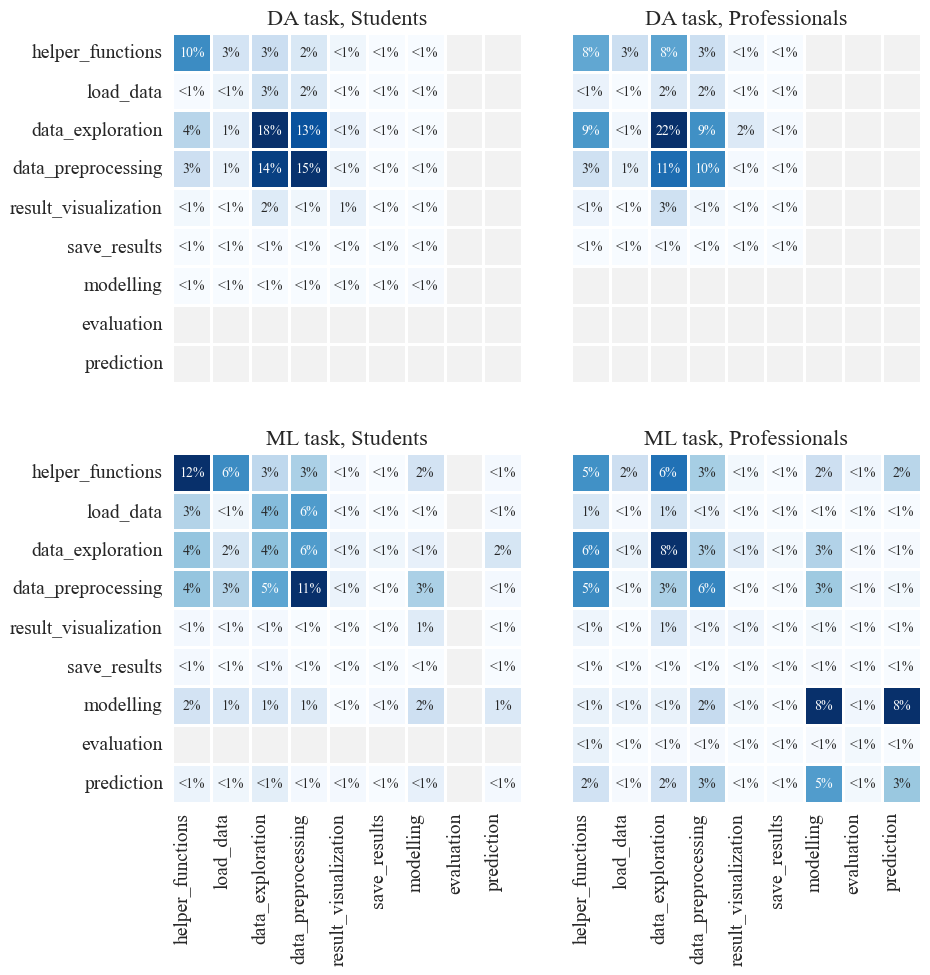

In [180]:
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["font.family"] = "Times New Roman"

fig_all, ax_all = plt.subplots(2, 2, figsize=(12, 10))

for i, task in enumerate(['task1', 'task2']):
    for j, expert in enumerate([False, True]):
        grouped_transitions = all_transitions_merged.groupby("inner_transition").get_group(False) \
            .groupby(['task', 'expert']).get_group((task, expert)) \
            .groupby(['cell_label_from']).cell_label_to.value_counts() \
            .reset_index().rename({"count": "transitions_count"}, axis=1)

        grouped_transitions[
            'probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

        transitions_matrix = grouped_transitions.pivot(
            index='cell_label_from', columns='cell_label_to', values='probability'
        ).fillna(0)

        print(
            "DA task" if task == "task1" else "ML task", "\t",
            "Professionals" if expert else "Students", "\t",
            get_working_with_data_ratio(transitions_matrix, extended=False)
        )
        ax_all[i][j].set_title(
            f"{'DA task' if task == 'task1' else 'ML task'}, {'Professionals' if expert else 'Students'}", fontsize=16
        )
        fig_all, ax_all[i][j] = plot_transitions_matrix(transitions_matrix, (fig_all, ax_all[i][j]))
        ax_all[i][j].tick_params(axis='both', which='major', labelsize=14)
        ax_all[i][j].tick_params(axis='both', which='minor', labelsize=8)

ax_all[0, 0].set_xticks([])
ax_all[0, 1].set_xticks([])
ax_all[0, 1].set_yticks([])
ax_all[1, 1].set_yticks([])
plt.subplots_adjust(wspace=-0.25)

plt.savefig(f'figures/transitions/outer_transitions_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [181]:
transitions_matrix.sum().sum()


1.0

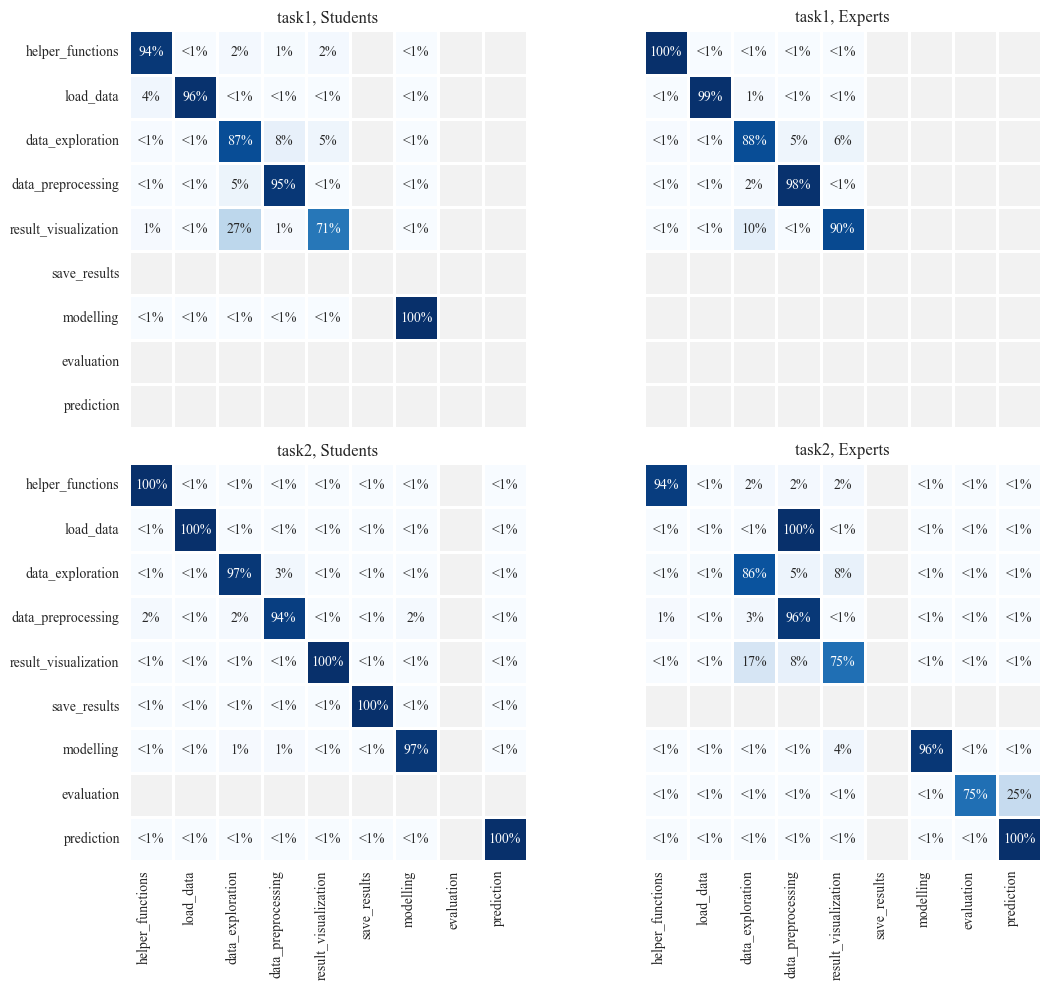

In [182]:
fig_all, ax_all = plt.subplots(2, 2, figsize=(12, 10))

for i, task in enumerate(['task1', 'task2']):
    for j, expert in enumerate([False, True]):
        grouped_transitions = all_transitions_merged.groupby("inner_transition").get_group(True) \
            .groupby(['task', 'expert']).get_group((task, expert)) \
            .groupby(['cell_label_from']).cell_label_to.value_counts(normalize=True) \
            .reset_index().rename({"proportion": "probability"}, axis=1)

        transitions_matrix = grouped_transitions.pivot(
            index='cell_label_from', columns='cell_label_to', values='probability'
        ).fillna(0)
        ax_all[i][j].set_title(f"{task}, {'Experts' if expert else 'Students'}")
        fig_all, ax_all[i][j] = plot_transitions_matrix(transitions_matrix, (fig_all, ax_all[i][j]))

ax_all[0, 0].set_xticks([])
ax_all[0, 1].set_xticks([])
ax_all[0, 1].set_yticks([])
ax_all[1, 1].set_yticks([])

plt.tight_layout()

plt.savefig(f'figures/transitions/inner_transitions_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Self-transitions analysis

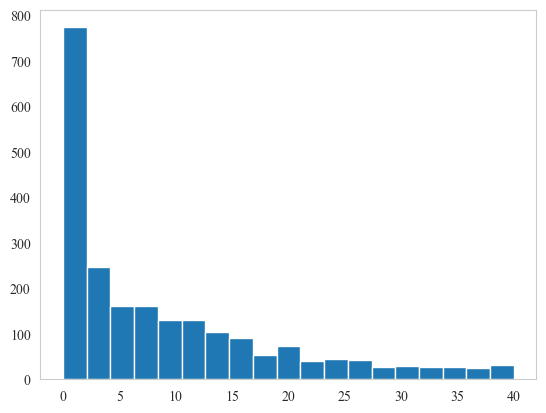

In [183]:
inner_transitions = all_transitions_merged.groupby("inner_transition").get_group(True)

inner_transitions['code_distance'] = inner_transitions.fillna("") \
    .apply(lambda row: distance(row['cell_source_from'], row['cell_source_to']), axis=1)
inner_transitions.groupby(["task", 'expert']).code_distance.describe()

inner_transitions['code_distance_percent'] = (
        inner_transitions.code_distance / inner_transitions.cell_source_from.str.len()
)

bins = np.linspace(0, 40, 20)
plt.hist(inner_transitions.code_distance.to_numpy(), bins=bins);


In [184]:
inner_transitions.groupby(["task", 'expert']).code_distance.median()


task   expert
task1  False     8.0
       True      7.5
task2  False     8.0
       True      8.0
Name: code_distance, dtype: float64

In [185]:
print(np.around(inner_transitions.code_distance_percent.median() * 100, 1), '%')


6.2 %


In [186]:
inner_transitions.code_distance.median()


8.0

In [187]:
print(
    np.round(
        (inner_transitions[inner_transitions['code_distance'] == 0].shape[0]
         / inner_transitions.shape[0]) * 100, 1
    ), '%'
)


10.0 %


## Example of changes after self-transition

In [188]:
sample = inner_transitions[
    (inner_transitions['code_distance'] < 8)
    & (inner_transitions['code_distance'] > 0)
    ].iloc[100]

print(sample.cell_source_from, f"\n{'=' * 10}\n", sample.cell_source_to)


dt = datetime(2023, 6, 5)

# Get the weekday
weekday = dt.weekday()

print(weekday) 
 dt = datetime(2023, 12, 31)

# Get the weekday
weekday = dt.weekday()

print(weekday)
